# IMDB Sentiment Analysis With Transformer Encoder

用 Bert + Transformer 的编码器部分 + 全连接层 做 IMDB 电影评论文本情感分析。

In [1]:
# conda install -c conda-forge transformers

In [2]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from swifter import swifter

import util
import sentiment_dataset as sed

In [3]:
EN_BERT_PATH = './data/bert-base-uncased'
IMDB_FILE = './data/IMDB Dataset.csv'
MODEL_FILE = './data/model_weight.pth'

batch_size, num_epochs = 25, 15

## 1. 数据预处理

In [4]:
df = pd.read_csv(IMDB_FILE)
df = df.sample(n=100)
df.head(10)

,review,sentiment
6552,When it comes to creating a universe George Lu...,positive
21675,The original with Barbara Stanwyk is saved onl...,positive
44097,"**SPOILERS** I rented ""Tesis"" (or ""Thesis"" in ...",negative
4101,For all the viewers who have seen 'The Cure' w...,positive
7869,"The cast is excellent, the acting good, the pl...",positive
7728,Very good drama about a young girl who attempt...,positive
41166,Chase has created a true phenomenon with The S...,positive
4827,I am writing this after just seeing The Perfec...,positive
35647,At first sight this is yet another highschool ...,positive
23625,"I wonder who, how and more importantly why the...",negative


In [5]:
df['sentiment'].value_counts()

sentiment
positive    56
negative    44
Name: count, dtype: int64

In [6]:
# 去除 html 标签
def remove_html_label(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

X = df['review'].swifter.apply(remove_html_label).tolist()
y = df['sentiment'].swifter.apply(lambda e: 1 if e == 'positive' else 0).tolist()

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
# 看一下 corpus 的 平均长度 和 最大长度
l = [len(x) for x in X]
np.mean(l), np.max(l)

(1432.85, 5094)

## 2. 加载数据集

将数据集分割成训练集和测试集，然后用 Dataset 的子类 `SentimentDataset` 加载训练集和测试集。

为了程序能在多线程环境下正确运行，将以下代码写入 `sentiment_dataset.py` 文件并导入。

```python
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }
```

In [8]:
# 分割训练集和测试集（其实是验证集）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=80)

tokenizer = BertTokenizer.from_pretrained(EN_BERT_PATH)

train_dataset = sed.SentimentDataset(X_train, y_train, tokenizer, max_len=512)
test_dataset = sed.SentimentDataset(X_test, y_test, tokenizer, max_len=512)

# train_dataset[13]

In [9]:
len(train_dataset)

80

In [10]:
# 用 DataLoader 加载数据
train_iter = DataLoader(train_dataset,
                        batch_size,
                        shuffle=True,
                        num_workers=4)
test_iter = DataLoader(test_dataset,
                       batch_size,
                       shuffle=True,
                       num_workers=4)

In [11]:
test_iter

## 3. 定义模型

我们的模型结构是 Bert + TransformerEncoder，注意这里 Bert 的参数是可更新的。

图省事直接用 `torch.nn` 写

- [nn.TransformerEncoderLayer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html)
- [nn.TransformerEncoder](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)

In [21]:
class BertTransformerEncoder(nn.Module):
    def __init__(self, n_classes, nhead=8, d_model=768, num_layers=6, freeze_bert=False):
        super().__init__()
        self.bert = BertModel.from_pretrained(EN_BERT_PATH)

        # Freeze BERT parameters
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.drop = nn.Dropout(p=0.2)
        self.out = nn.Linear(d_model, n_classes)

    def forward(self, input_ids, attention_mask):
        # 用 bert 代替 nn.Embedding
        bert_outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        encoder_hidden_states = bert_outputs.last_hidden_state  # [batch_size, seq_len, hidden_dim]

        # transformer encoder -> pooling -> dropout -> fully_connected_layer
        encoded_output = self.transformer_encoder(encoder_hidden_states)
        # 通过池化获得句子级别的表征
        pooled_output = encoded_output.mean(dim=1)
        # 通过 dropout 防止过拟合
        x = self.drop(pooled_output)
        # 最后接一个全连接层
        return self.out(x)

In [22]:
# 定义模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def create_model(freeze_bert, device, n_classes=2):
    net = BertTransformerEncoder(n_classes=n_classes, freeze_bert=freeze_bert)

    # 权重初始化
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Embedding):
            torch.nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    return net.to(device)

net = create_model(freeze_bert=False, device=device)

In [14]:
# 损失函数
loss = nn.CrossEntropyLoss(reduction='none')

# 优化器
optimizer = torch.optim.Adam(net.parameters())

## 4. 训练模型

In [15]:
def evaluate_accuracy(net, data_iter, device):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = util.Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for data in data_iter:
            y_hat = net(input_ids=data['input_ids'].to(device),
                        attention_mask=data['attention_mask'].to(device))
            y = data['label'].to(device)
            metric.add(util.accuracy(y_hat, y), y.numel())
    return metric[0] / metric[1]

In [16]:
def train_epoch(net, train_iter, loss, updater, device):
    """训练模型一个迭代周期"""

    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()

    # 训练损失总和、训练准确度总和、样本数
    metric = util.Accumulator(3)
    for data in train_iter:
        # 计算梯度并更新参数
        y_hat = net(input_ids=data['input_ids'].to(device),
                      attention_mask=data['attention_mask'].to(device))

        y = data['label'].to(device)
        l = loss(y_hat, y)

        # 使用PyTorch内置的优化器和损失函数
        updater.zero_grad()
        l.mean().backward()
        updater.step()

        metric.add(float(l.sum()), util.accuracy(y_hat, y), y.numel())

    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [17]:
def train(net, train_iter, test_iter, loss, num_epochs, updater, device):
    """训练模型"""
    animator = util.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater, device)
        test_acc = evaluate_accuracy(net, test_iter, device)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics

    print(f'train_loss: {train_loss:.3f}')
    print(f'train_acc: {train_acc:.3f}')
    print(f'test_acc: {test_acc:.3f}')

train_loss: 0.740
train_acc: 0.575
test_acc: 0.500


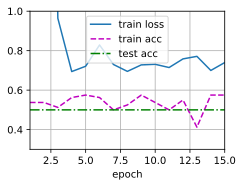

In [18]:
train(net=net,
      train_iter=train_iter,
      test_iter=test_iter,
      loss=loss,
      num_epochs=num_epochs,
      updater=optimizer,
      device=device)

因为电脑性能的原因，只用了 100 个句子 + 15 个 epochs 进行训练。

随着训练轮次的增加，loss 似乎还有继续下降的潜力。

In [19]:
# 保存模型权重
torch.save(net.state_dict(), MODEL_FILE)

train_loss: 0.738
train_acc: 0.625
test_acc: 0.500


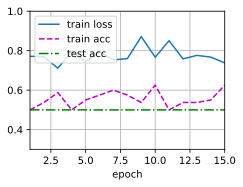

In [20]:
# 固定 Bert 的权重，再训练一遍
new_net = create_model(freeze_bert=True)
train(net=new_net,
      train_iter=train_iter,
      test_iter=test_iter,
      loss=loss,
      num_epochs=num_epochs,
      updater=optimizer,
      device=device)